In [10]:
import torch
import os 
from pathlib import Path

# El alto y ancho de las imágenes debe ser divisible por 16 para que concidan las dimensiones de las capas 
# convolucionales y convolucionales transpuestas.
path = Path('./DataSet')
imgs = [path/'ImagenesPNpy'/i for i in os.listdir(path/'ImagenesPNpy')]
masks = [path/'MascarasPNpy'/i for i in os.listdir(path/'MascarasPNpy')]

imgs= sorted(imgs)
masks= sorted(masks)

len(imgs), len(masks)

(396, 396)

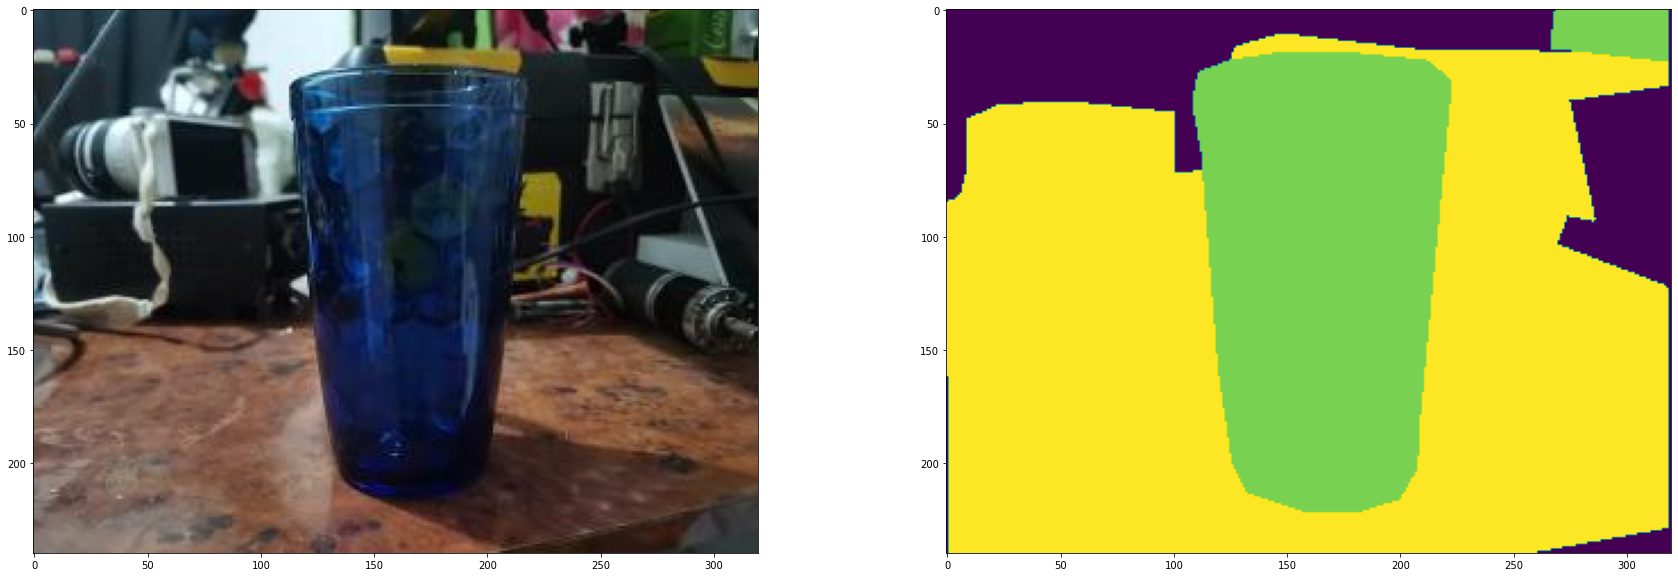

DataSet/ImagenesPNpy/Timagen10.npy
(240, 320)
396
396
DataSet/ImagenesPNpy/Timagen10.npy
DataSet/MascarasPNpy/Timagen10.npy
DataSet/ImagenesPNpy/Timagen101.npy
DataSet/MascarasPNpy/Timagen101.npy
DataSet/ImagenesPNpy/Timagen116.npy
DataSet/MascarasPNpy/Timagen116.npy
DataSet/ImagenesPNpy/Timagen166.npy
DataSet/MascarasPNpy/Timagen166.npy
DataSet/ImagenesPNpy/Timagen171.npy
DataSet/MascarasPNpy/Timagen171.npy
DataSet/ImagenesPNpy/Timagen174.npy
DataSet/MascarasPNpy/Timagen174.npy
DataSet/ImagenesPNpy/Timagen176.npy
DataSet/MascarasPNpy/Timagen176.npy
DataSet/ImagenesPNpy/Timagen180.npy
DataSet/MascarasPNpy/Timagen180.npy
DataSet/ImagenesPNpy/Timagen206.npy
DataSet/MascarasPNpy/Timagen206.npy
DataSet/ImagenesPNpy/Timagen209.npy
DataSet/MascarasPNpy/Timagen209.npy
DataSet/ImagenesPNpy/Timagen220.npy
DataSet/MascarasPNpy/Timagen220.npy
DataSet/ImagenesPNpy/Timagen226.npy
DataSet/MascarasPNpy/Timagen226.npy
DataSet/ImagenesPNpy/Timagen235.npy
DataSet/MascarasPNpy/Timagen235.npy
DataSet/Imag

DataSet/ImagenesPNpy/imagen357.npy
DataSet/MascarasPNpy/imagen357.npy
DataSet/ImagenesPNpy/imagen358.npy
DataSet/MascarasPNpy/imagen358.npy
DataSet/ImagenesPNpy/imagen359.npy
DataSet/MascarasPNpy/imagen359.npy
DataSet/ImagenesPNpy/imagen36.npy
DataSet/MascarasPNpy/imagen36.npy
DataSet/ImagenesPNpy/imagen360.npy
DataSet/MascarasPNpy/imagen360.npy
DataSet/ImagenesPNpy/imagen361.npy
DataSet/MascarasPNpy/imagen361.npy
DataSet/ImagenesPNpy/imagen363.npy
DataSet/MascarasPNpy/imagen363.npy
DataSet/ImagenesPNpy/imagen364.npy
DataSet/MascarasPNpy/imagen364.npy
DataSet/ImagenesPNpy/imagen365.npy
DataSet/MascarasPNpy/imagen365.npy
DataSet/ImagenesPNpy/imagen366.npy
DataSet/MascarasPNpy/imagen366.npy
DataSet/ImagenesPNpy/imagen367.npy
DataSet/MascarasPNpy/imagen367.npy
DataSet/ImagenesPNpy/imagen368.npy
DataSet/MascarasPNpy/imagen368.npy
DataSet/ImagenesPNpy/imagen369.npy
DataSet/MascarasPNpy/imagen369.npy
DataSet/ImagenesPNpy/imagen37.npy
DataSet/MascarasPNpy/imagen37.npy
DataSet/ImagenesPNpy/ima

In [11]:
import matplotlib.pyplot as plt
import numpy as np

i=0
while i<1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    img = np.load(imgs[i])
    mask = np.load(masks[i])
    ax1.imshow(torch.from_numpy(img).permute(1,2,0).numpy())
    ax2.imshow(mask)
    plt.show()
    print(imgs[i])
    print(mask.shape)
    i+=1

print(len(masks))
print(len(imgs)) 

i=0
pool=True
while i<310:
    img = np.load(imgs[i])
    mask = np.load(masks[i])
    if img.shape != (3, 480, 640):
        pool=False
        print(imgs[i])
    if mask.shape != (480, 640):
        print(masks[i])
        pool=False

    i=i+1

if pool==True:
    print((480, 640))
        
    

In [14]:
import numpy as np
import torchvision 

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=10):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    #img = torch.tensor(img).unsqueeze(0) Para el caso donde se trabaje con un solo canal
    img = torch.tensor(img) # Para el caso donde se trabaje con tres canales 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [15]:
dataset = {
    'train': Dataset(imgs[47:], masks[47:]),
    'test': Dataset(imgs[:47], masks[:47])
}

len(dataset['train']), len(dataset['test'])

(349, 47)

In [16]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([10, 3, 240, 320]), torch.Size([10, 10, 240, 320]))

In [17]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=10, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        #x = self.encoder.maxpool(x)
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [18]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [19]:
import uuid
uuid=uuid.uuid1()

In [20]:
from tqdm import tqdm
import uuid
uuid=uuid.uuid1()

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=0.001, wd=1e-3):
    ant=0.05
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          if loss<ant:
            torch.save(model,'modelo' +str(loss) +'.pt')
            ant=loss
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [17]:
import torchvision
import torch.nn.functional as F

class out_conv(torch.nn.Module):
    def __init__(self, ci, co):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=16, stride=8, padding=4)
        self.final = torch.nn.Conv2d(co*2, co, kernel_size=7, stride=1, padding=3)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=7, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        self.encoder = torch.nn.Sequential(*list(self.encoder.children())[:-4])
        self.out = out_conv(128, n_classes)

    def forward(self, x):
        capas = list(self.encoder.children())
        x_in = x.clone().detach()
        x = capas[0](x)
        x = capas[1](x)
        x = capas[2](x)
        x = capas[3](x)
        x = capas[4](x)
        x = capas[5](x)
        x = self.out(x, x_in)
        return x

In [21]:
model = UNetResnet()
#print(model)
hist = fit(model, dataloader, epochs=100)

test_loss 0.36380 test_iou 0.61871: 100%|█████████| 5/5 [00:00<00:00,  7.47it/s]



Epoch 1/100 loss 0.50974 iou 0.39581 test_loss 0.36380 test_iou 0.61871


test_loss 0.21646 test_iou 0.65117: 100%|█████████| 5/5 [00:00<00:00,  7.54it/s]



Epoch 2/100 loss 0.27660 iou 0.63658 test_loss 0.21646 test_iou 0.65117


test_loss 0.17328 test_iou 0.65676: 100%|█████████| 5/5 [00:00<00:00,  7.61it/s]



Epoch 3/100 loss 0.18395 iou 0.64287 test_loss 0.17328 test_iou 0.65676


test_loss 0.15380 test_iou 0.66305: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 4/100 loss 0.14981 iou 0.65076 test_loss 0.15380 test_iou 0.66305


test_loss 0.12791 test_iou 0.68334: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 5/100 loss 0.12547 iou 0.65795 test_loss 0.12791 test_iou 0.68334


test_loss 0.11089 test_iou 0.66618: 100%|█████████| 5/5 [00:00<00:00,  7.50it/s]



Epoch 6/100 loss 0.10903 iou 0.66175 test_loss 0.11089 test_iou 0.66618


test_loss 0.11633 test_iou 0.68060: 100%|█████████| 5/5 [00:00<00:00,  7.48it/s]



Epoch 7/100 loss 0.09723 iou 0.67392 test_loss 0.11633 test_iou 0.68060


test_loss 0.10979 test_iou 0.67318: 100%|█████████| 5/5 [00:00<00:00,  7.62it/s]



Epoch 8/100 loss 0.09281 iou 0.67699 test_loss 0.10979 test_iou 0.67318


test_loss 0.11222 test_iou 0.66345: 100%|█████████| 5/5 [00:00<00:00,  7.12it/s]



Epoch 9/100 loss 0.08785 iou 0.67839 test_loss 0.11222 test_iou 0.66345


test_loss 0.10723 test_iou 0.64829: 100%|█████████| 5/5 [00:00<00:00,  7.32it/s]



Epoch 10/100 loss 0.07772 iou 0.69049 test_loss 0.10723 test_iou 0.64829


test_loss 0.08400 test_iou 0.67958: 100%|█████████| 5/5 [00:00<00:00,  7.52it/s]



Epoch 11/100 loss 0.07125 iou 0.69331 test_loss 0.08400 test_iou 0.67958


test_loss 0.08046 test_iou 0.70579:  40%|███▌     | 2/5 [00:00<00:00,  6.81it/s]/home/posgrado/.local/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type UNetResnet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/posgrado/.local/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type deconv. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/posgrado/.local/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type out_conv. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
test_loss 0.07600 test_iou 0.70094: 100%|█████████| 5/5 [00:00<00:00,  6.47it/s]



Epoch 12/100 loss 0.06303 iou 0.70540 test_loss 0.07600 test_iou 0.70094


test_loss 0.07213 test_iou 0.70821: 100%|█████████| 5/5 [00:00<00:00,  6.58it/s]



Epoch 13/100 loss 0.05702 iou 0.71696 test_loss 0.07213 test_iou 0.70821


test_loss 0.07171 test_iou 0.69577: 100%|█████████| 5/5 [00:00<00:00,  7.40it/s]



Epoch 14/100 loss 0.05183 iou 0.71769 test_loss 0.07171 test_iou 0.69577


test_loss 0.07722 test_iou 0.69858: 100%|█████████| 5/5 [00:00<00:00,  7.30it/s]



Epoch 15/100 loss 0.04953 iou 0.72265 test_loss 0.07722 test_iou 0.69858


test_loss 0.08544 test_iou 0.67623: 100%|█████████| 5/5 [00:00<00:00,  7.34it/s]



Epoch 16/100 loss 0.04836 iou 0.70781 test_loss 0.08544 test_iou 0.67623


test_loss 0.06902 test_iou 0.66194: 100%|█████████| 5/5 [00:00<00:00,  7.27it/s]



Epoch 17/100 loss 0.04430 iou 0.71276 test_loss 0.06902 test_iou 0.66194


test_loss 0.06088 test_iou 0.72995: 100%|█████████| 5/5 [00:00<00:00,  6.67it/s]



Epoch 18/100 loss 0.04166 iou 0.71450 test_loss 0.06088 test_iou 0.72995


test_loss 0.05856 test_iou 0.71330: 100%|█████████| 5/5 [00:00<00:00,  6.84it/s]



Epoch 19/100 loss 0.03955 iou 0.72107 test_loss 0.05856 test_iou 0.71330


test_loss 0.07135 test_iou 0.64770: 100%|█████████| 5/5 [00:00<00:00,  7.43it/s]



Epoch 20/100 loss 0.03945 iou 0.72261 test_loss 0.07135 test_iou 0.64770


test_loss 0.06491 test_iou 0.69566: 100%|█████████| 5/5 [00:00<00:00,  7.33it/s]



Epoch 21/100 loss 0.03979 iou 0.70594 test_loss 0.06491 test_iou 0.69566


test_loss 0.07198 test_iou 0.57970: 100%|█████████| 5/5 [00:00<00:00,  7.43it/s]



Epoch 22/100 loss 0.03766 iou 0.71476 test_loss 0.07198 test_iou 0.57970


test_loss 0.06717 test_iou 0.68288: 100%|█████████| 5/5 [00:00<00:00,  7.36it/s]



Epoch 23/100 loss 0.03781 iou 0.70556 test_loss 0.06717 test_iou 0.68288


test_loss 0.06231 test_iou 0.71890: 100%|█████████| 5/5 [00:00<00:00,  7.26it/s]



Epoch 24/100 loss 0.03327 iou 0.73328 test_loss 0.06231 test_iou 0.71890


test_loss 0.05260 test_iou 0.73625: 100%|█████████| 5/5 [00:00<00:00,  6.76it/s]



Epoch 25/100 loss 0.02984 iou 0.75069 test_loss 0.05260 test_iou 0.73625


test_loss 0.05320 test_iou 0.73158: 100%|█████████| 5/5 [00:00<00:00,  6.23it/s]



Epoch 26/100 loss 0.02590 iou 0.77020 test_loss 0.05320 test_iou 0.73158


test_loss 0.05399 test_iou 0.73997: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 27/100 loss 0.02371 iou 0.78516 test_loss 0.05399 test_iou 0.73997


test_loss 0.05400 test_iou 0.75751: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 28/100 loss 0.02238 iou 0.78425 test_loss 0.05400 test_iou 0.75751


test_loss 0.05637 test_iou 0.75857: 100%|█████████| 5/5 [00:00<00:00,  7.40it/s]



Epoch 29/100 loss 0.02176 iou 0.79702 test_loss 0.05637 test_iou 0.75857


test_loss 0.06101 test_iou 0.75268: 100%|█████████| 5/5 [00:00<00:00,  7.66it/s]



Epoch 30/100 loss 0.02089 iou 0.79167 test_loss 0.06101 test_iou 0.75268


test_loss 0.05392 test_iou 0.73653: 100%|█████████| 5/5 [00:00<00:00,  6.90it/s]



Epoch 31/100 loss 0.02040 iou 0.79418 test_loss 0.05392 test_iou 0.73653


test_loss 0.05353 test_iou 0.75828: 100%|█████████| 5/5 [00:00<00:00,  6.74it/s]



Epoch 32/100 loss 0.01955 iou 0.80057 test_loss 0.05353 test_iou 0.75828


test_loss 0.05260 test_iou 0.73660: 100%|█████████| 5/5 [00:00<00:00,  7.48it/s]



Epoch 33/100 loss 0.01863 iou 0.80021 test_loss 0.05260 test_iou 0.73660


test_loss 0.06259 test_iou 0.73278: 100%|█████████| 5/5 [00:00<00:00,  7.33it/s]



Epoch 34/100 loss 0.01940 iou 0.80190 test_loss 0.06259 test_iou 0.73278


test_loss 0.08052 test_iou 0.68966: 100%|█████████| 5/5 [00:00<00:00,  7.46it/s]



Epoch 35/100 loss 0.02132 iou 0.77925 test_loss 0.08052 test_iou 0.68966


test_loss 0.14929 test_iou 0.51820: 100%|█████████| 5/5 [00:00<00:00,  7.68it/s]



Epoch 36/100 loss 0.03291 iou 0.74978 test_loss 0.14929 test_iou 0.51820


test_loss 0.06702 test_iou 0.67873: 100%|█████████| 5/5 [00:00<00:00,  7.64it/s]



Epoch 37/100 loss 0.04324 iou 0.69630 test_loss 0.06702 test_iou 0.67873


test_loss 0.05367 test_iou 0.74501: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 38/100 loss 0.02605 iou 0.76902 test_loss 0.05367 test_iou 0.74501


test_loss 0.05540 test_iou 0.76644: 100%|█████████| 5/5 [00:00<00:00,  7.59it/s]



Epoch 39/100 loss 0.02237 iou 0.79607 test_loss 0.05540 test_iou 0.76644


test_loss 0.05517 test_iou 0.76501: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 40/100 loss 0.01920 iou 0.80237 test_loss 0.05517 test_iou 0.76501


test_loss 0.05579 test_iou 0.76657: 100%|█████████| 5/5 [00:00<00:00,  7.71it/s]



Epoch 41/100 loss 0.01797 iou 0.81302 test_loss 0.05579 test_iou 0.76657


test_loss 0.06738 test_iou 0.74913: 100%|█████████| 5/5 [00:00<00:00,  7.46it/s]



Epoch 42/100 loss 0.01656 iou 0.82734 test_loss 0.06738 test_iou 0.74913


test_loss 0.05870 test_iou 0.68559: 100%|█████████| 5/5 [00:00<00:00,  7.57it/s]



Epoch 43/100 loss 0.01821 iou 0.81243 test_loss 0.05870 test_iou 0.68559


test_loss 0.05752 test_iou 0.77554: 100%|█████████| 5/5 [00:00<00:00,  7.46it/s]



Epoch 44/100 loss 0.01696 iou 0.81491 test_loss 0.05752 test_iou 0.77554


test_loss 0.05130 test_iou 0.78105: 100%|█████████| 5/5 [00:00<00:00,  7.54it/s]



Epoch 45/100 loss 0.01561 iou 0.81812 test_loss 0.05130 test_iou 0.78105


test_loss 0.05537 test_iou 0.78476: 100%|█████████| 5/5 [00:00<00:00,  7.38it/s]



Epoch 46/100 loss 0.01362 iou 0.84108 test_loss 0.05537 test_iou 0.78476


test_loss 0.05589 test_iou 0.78831: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 47/100 loss 0.01266 iou 0.84297 test_loss 0.05589 test_iou 0.78831


test_loss 0.05157 test_iou 0.78593: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 48/100 loss 0.01203 iou 0.84798 test_loss 0.05157 test_iou 0.78593


test_loss 0.05434 test_iou 0.78909: 100%|█████████| 5/5 [00:00<00:00,  7.65it/s]



Epoch 49/100 loss 0.01183 iou 0.85441 test_loss 0.05434 test_iou 0.78909


test_loss 0.05297 test_iou 0.78114: 100%|█████████| 5/5 [00:00<00:00,  7.67it/s]



Epoch 50/100 loss 0.01184 iou 0.85432 test_loss 0.05297 test_iou 0.78114


test_loss 0.05465 test_iou 0.78888: 100%|█████████| 5/5 [00:00<00:00,  7.61it/s]



Epoch 51/100 loss 0.01140 iou 0.85553 test_loss 0.05465 test_iou 0.78888


test_loss 0.05462 test_iou 0.78712: 100%|█████████| 5/5 [00:00<00:00,  7.32it/s]



Epoch 52/100 loss 0.01083 iou 0.85681 test_loss 0.05462 test_iou 0.78712


test_loss 0.05481 test_iou 0.79030: 100%|█████████| 5/5 [00:00<00:00,  7.65it/s]



Epoch 53/100 loss 0.01007 iou 0.86166 test_loss 0.05481 test_iou 0.79030


test_loss 0.05465 test_iou 0.79029: 100%|█████████| 5/5 [00:00<00:00,  7.33it/s]



Epoch 54/100 loss 0.01042 iou 0.86228 test_loss 0.05465 test_iou 0.79029


test_loss 0.05713 test_iou 0.79229: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 55/100 loss 0.01023 iou 0.85903 test_loss 0.05713 test_iou 0.79229


test_loss 0.06000 test_iou 0.77268: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 56/100 loss 0.00938 iou 0.86739 test_loss 0.06000 test_iou 0.77268


test_loss 0.05872 test_iou 0.78494: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 57/100 loss 0.00943 iou 0.86530 test_loss 0.05872 test_iou 0.78494


test_loss 0.06072 test_iou 0.79233: 100%|█████████| 5/5 [00:00<00:00,  7.36it/s]



Epoch 58/100 loss 0.01006 iou 0.86369 test_loss 0.06072 test_iou 0.79233


test_loss 0.05523 test_iou 0.78062: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 59/100 loss 0.01037 iou 0.86090 test_loss 0.05523 test_iou 0.78062


test_loss 0.05971 test_iou 0.77667: 100%|█████████| 5/5 [00:00<00:00,  7.39it/s]



Epoch 60/100 loss 0.01006 iou 0.85756 test_loss 0.05971 test_iou 0.77667


test_loss 0.06294 test_iou 0.73859: 100%|█████████| 5/5 [00:00<00:00,  7.40it/s]



Epoch 61/100 loss 0.00953 iou 0.85983 test_loss 0.06294 test_iou 0.73859


test_loss 0.06327 test_iou 0.79846: 100%|█████████| 5/5 [00:00<00:00,  7.43it/s]



Epoch 62/100 loss 0.00916 iou 0.86903 test_loss 0.06327 test_iou 0.79846


test_loss 0.06328 test_iou 0.79318: 100%|█████████| 5/5 [00:00<00:00,  7.31it/s]



Epoch 63/100 loss 0.00888 iou 0.86930 test_loss 0.06328 test_iou 0.79318


test_loss 0.06437 test_iou 0.75087: 100%|█████████| 5/5 [00:00<00:00,  7.49it/s]



Epoch 64/100 loss 0.00921 iou 0.85912 test_loss 0.06437 test_iou 0.75087


test_loss 0.06213 test_iou 0.78582: 100%|█████████| 5/5 [00:00<00:00,  7.61it/s]



Epoch 65/100 loss 0.01005 iou 0.85825 test_loss 0.06213 test_iou 0.78582


test_loss 0.05934 test_iou 0.75129: 100%|█████████| 5/5 [00:00<00:00,  7.56it/s]



Epoch 66/100 loss 0.00876 iou 0.86641 test_loss 0.05934 test_iou 0.75129


test_loss 0.06402 test_iou 0.77831: 100%|█████████| 5/5 [00:00<00:00,  7.36it/s]



Epoch 67/100 loss 0.00855 iou 0.86724 test_loss 0.06402 test_iou 0.77831


test_loss 0.05758 test_iou 0.79164: 100%|█████████| 5/5 [00:00<00:00,  7.36it/s]



Epoch 68/100 loss 0.00843 iou 0.87274 test_loss 0.05758 test_iou 0.79164


test_loss 0.06255 test_iou 0.79787: 100%|█████████| 5/5 [00:00<00:00,  7.62it/s]



Epoch 69/100 loss 0.00792 iou 0.87586 test_loss 0.06255 test_iou 0.79787


test_loss 0.06433 test_iou 0.77986: 100%|█████████| 5/5 [00:00<00:00,  7.34it/s]



Epoch 70/100 loss 0.00774 iou 0.87256 test_loss 0.06433 test_iou 0.77986


test_loss 0.06538 test_iou 0.66563: 100%|█████████| 5/5 [00:00<00:00,  7.61it/s]



Epoch 71/100 loss 0.00960 iou 0.86600 test_loss 0.06538 test_iou 0.66563


test_loss 0.07677 test_iou 0.75601: 100%|█████████| 5/5 [00:00<00:00,  7.44it/s]



Epoch 72/100 loss 0.01179 iou 0.83595 test_loss 0.07677 test_iou 0.75601


test_loss 0.06102 test_iou 0.77767: 100%|█████████| 5/5 [00:00<00:00,  7.64it/s]



Epoch 73/100 loss 0.01009 iou 0.85476 test_loss 0.06102 test_iou 0.77767


test_loss 0.06911 test_iou 0.80501: 100%|█████████| 5/5 [00:00<00:00,  7.62it/s]



Epoch 74/100 loss 0.00996 iou 0.85932 test_loss 0.06911 test_iou 0.80501


test_loss 0.06141 test_iou 0.78925: 100%|█████████| 5/5 [00:00<00:00,  7.58it/s]



Epoch 75/100 loss 0.00896 iou 0.86898 test_loss 0.06141 test_iou 0.78925


test_loss 0.06153 test_iou 0.78441: 100%|█████████| 5/5 [00:00<00:00,  7.35it/s]



Epoch 76/100 loss 0.00845 iou 0.86513 test_loss 0.06153 test_iou 0.78441


test_loss 0.05908 test_iou 0.78582: 100%|█████████| 5/5 [00:00<00:00,  7.41it/s]



Epoch 77/100 loss 0.00816 iou 0.87025 test_loss 0.05908 test_iou 0.78582


test_loss 0.06477 test_iou 0.79283: 100%|█████████| 5/5 [00:00<00:00,  7.33it/s]



Epoch 78/100 loss 0.00730 iou 0.87556 test_loss 0.06477 test_iou 0.79283


test_loss 0.06441 test_iou 0.78940: 100%|█████████| 5/5 [00:00<00:00,  7.74it/s]



Epoch 79/100 loss 0.00695 iou 0.87552 test_loss 0.06441 test_iou 0.78940


test_loss 0.06876 test_iou 0.80010: 100%|█████████| 5/5 [00:00<00:00,  7.69it/s]



Epoch 80/100 loss 0.00661 iou 0.88352 test_loss 0.06876 test_iou 0.80010


test_loss 0.24764 test_iou 0.36851: 100%|█████████| 5/5 [00:00<00:00,  7.33it/s]



Epoch 81/100 loss 0.01113 iou 0.84622 test_loss 0.24764 test_iou 0.36851


test_loss 0.23635 test_iou 0.55094: 100%|█████████| 5/5 [00:00<00:00,  7.43it/s]



Epoch 82/100 loss 0.07498 iou 0.64451 test_loss 0.23635 test_iou 0.55094


test_loss 0.07188 test_iou 0.64765: 100%|█████████| 5/5 [00:00<00:00,  7.66it/s]



Epoch 83/100 loss 0.04401 iou 0.69648 test_loss 0.07188 test_iou 0.64765


test_loss 0.06051 test_iou 0.73118: 100%|█████████| 5/5 [00:00<00:00,  7.38it/s]



Epoch 84/100 loss 0.02548 iou 0.73325 test_loss 0.06051 test_iou 0.73118


test_loss 0.05755 test_iou 0.76285: 100%|█████████| 5/5 [00:00<00:00,  7.42it/s]



Epoch 85/100 loss 0.01779 iou 0.78495 test_loss 0.05755 test_iou 0.76285


test_loss 0.09564 test_iou 0.70877: 100%|█████████| 5/5 [00:00<00:00,  7.36it/s]



Epoch 86/100 loss 0.01442 iou 0.81618 test_loss 0.09564 test_iou 0.70877


test_loss 0.05979 test_iou 0.72945: 100%|█████████| 5/5 [00:00<00:00,  7.39it/s]



Epoch 87/100 loss 0.01273 iou 0.82415 test_loss 0.05979 test_iou 0.72945


test_loss 0.05930 test_iou 0.75849: 100%|█████████| 5/5 [00:00<00:00,  7.37it/s]



Epoch 88/100 loss 0.01104 iou 0.84263 test_loss 0.05930 test_iou 0.75849


test_loss 0.05947 test_iou 0.74078: 100%|█████████| 5/5 [00:00<00:00,  7.57it/s]



Epoch 89/100 loss 0.01046 iou 0.83528 test_loss 0.05947 test_iou 0.74078


test_loss 0.06548 test_iou 0.76794: 100%|█████████| 5/5 [00:00<00:00,  7.65it/s]



Epoch 90/100 loss 0.00938 iou 0.84647 test_loss 0.06548 test_iou 0.76794


test_loss 0.06179 test_iou 0.77133: 100%|█████████| 5/5 [00:00<00:00,  7.44it/s]



Epoch 91/100 loss 0.00876 iou 0.85271 test_loss 0.06179 test_iou 0.77133


test_loss 0.07121 test_iou 0.76934: 100%|█████████| 5/5 [00:00<00:00,  7.38it/s]



Epoch 92/100 loss 0.00837 iou 0.85155 test_loss 0.07121 test_iou 0.76934


test_loss 0.06069 test_iou 0.74411: 100%|█████████| 5/5 [00:00<00:00,  7.63it/s]



Epoch 93/100 loss 0.00849 iou 0.85416 test_loss 0.06069 test_iou 0.74411


test_loss 0.06305 test_iou 0.75122: 100%|█████████| 5/5 [00:00<00:00,  7.29it/s]



Epoch 94/100 loss 0.00825 iou 0.86000 test_loss 0.06305 test_iou 0.75122


test_loss 0.06320 test_iou 0.74666: 100%|█████████| 5/5 [00:00<00:00,  7.54it/s]



Epoch 95/100 loss 0.00822 iou 0.85421 test_loss 0.06320 test_iou 0.74666


test_loss 0.06462 test_iou 0.77346: 100%|█████████| 5/5 [00:00<00:00,  7.45it/s]



Epoch 96/100 loss 0.00803 iou 0.86633 test_loss 0.06462 test_iou 0.77346


test_loss 0.06312 test_iou 0.75072: 100%|█████████| 5/5 [00:00<00:00,  7.39it/s]



Epoch 97/100 loss 0.00762 iou 0.86567 test_loss 0.06312 test_iou 0.75072


test_loss 0.06390 test_iou 0.75844: 100%|█████████| 5/5 [00:00<00:00,  7.31it/s]



Epoch 98/100 loss 0.00746 iou 0.86722 test_loss 0.06390 test_iou 0.75844


test_loss 0.06582 test_iou 0.76601: 100%|█████████| 5/5 [00:00<00:00,  7.51it/s]



Epoch 99/100 loss 0.00676 iou 0.87494 test_loss 0.06582 test_iou 0.76601


test_loss 0.07024 test_iou 0.76395: 100%|█████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch 100/100 loss 0.00641 iou 0.87202 test_loss 0.07024 test_iou 0.76395


Epoch 10/10 loss 0.06984 iou 0.76055 test_loss 0.05955 test_iou 0.77610 --  
Epoch 30/30 loss 0.02229 iou 0.80324 test_loss 0.04631 test_iou 0.79112 --  
Epoch 100/100 loss 0.00468 iou 0.92331 test_loss 0.05078 test_iou 0.76159  

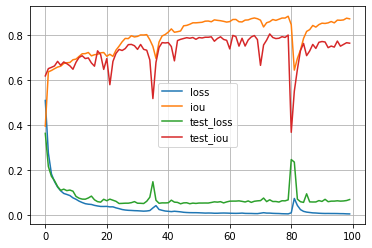

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [26]:
ix=0

0.011543035507202148


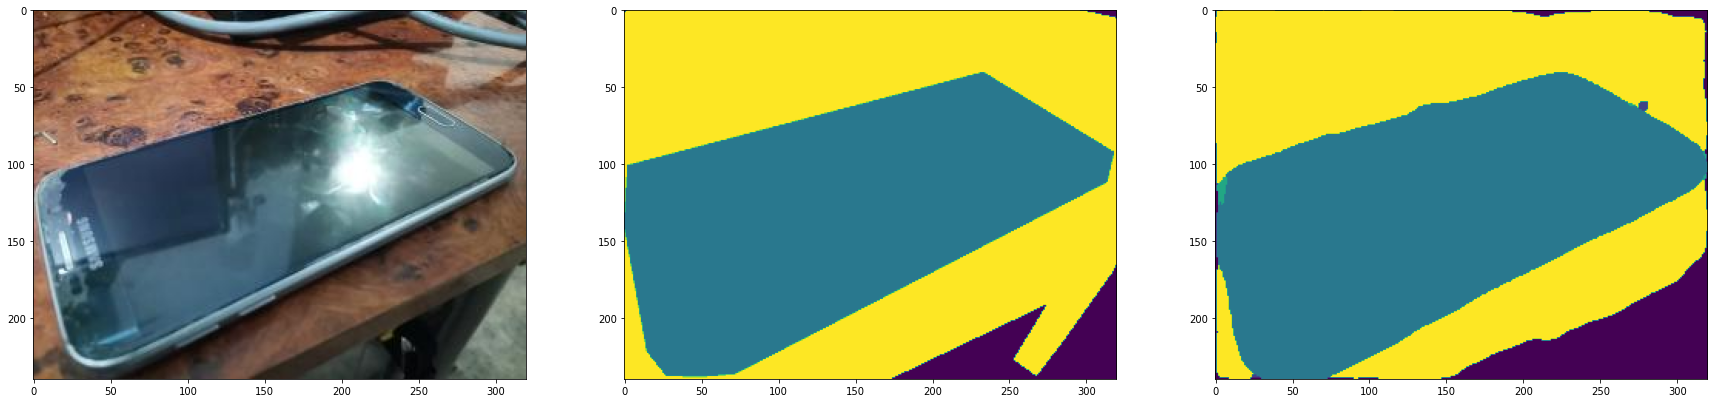

In [70]:
import random
import time

ix= ix+1
model.eval()
with torch.no_grad():
    #ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    inicio=time.time()
    output = model(img.unsqueeze(0).to(device))[0]
    termino=time.time()
    print(termino-inicio)
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()


In [68]:
#Para cargar una red ya entrenada
import torch
torch.save(model,'modelo.pt')
#model = torch.load('model.pt',map_location='cpu')

In [69]:
# Para predecir con el modelo entrenado y mostrar como imagen la mascara generada
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./imagen.jpg')
imagen=imagen.float()/255
model.eval()
with torch.no_grad():
    output = model(imagen.unsqueeze(0).to(device))[0]
    mascara_pred = torch.argmax(output, axis=0)
np.save('./mascara',mascara_pred.numpy())
print(imagen.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(imagen.squeeze(0).permute(1,2,0))
ax2.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

AttributeError: module 'torchvision.io' has no attribute 'read_image'

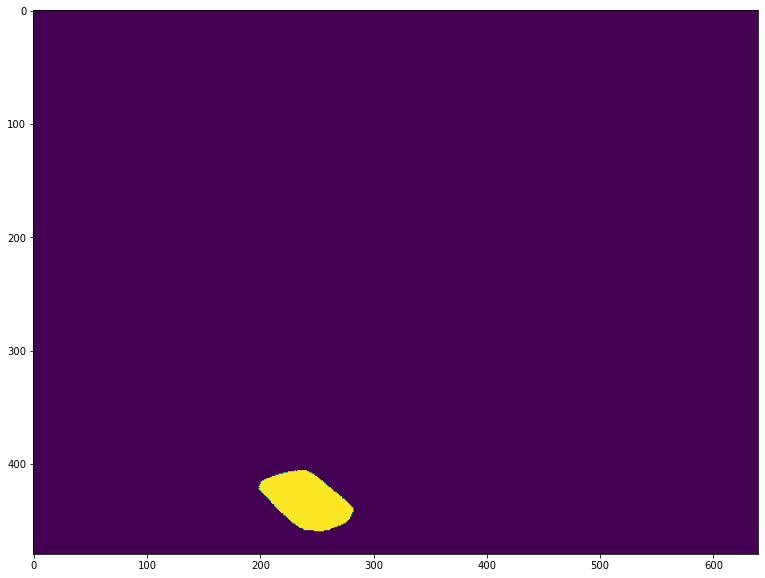

In [28]:
# Para abrir como imagen la mascara.npy generada en la Raspberry
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
mascara_pred=np.load('./mascara.npy')
mascara_pred=torch.tensor(mascara_pred)
fig, (ax1) = plt.subplots(1, 1, figsize=(30,10))
ax1.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()